# Guia Prático de Análise de Séries Temporais (E-commerce)

Este notebook implementa, passo a passo, o guia prático de séries temporais usando três datasets do e-commerce:

- Updated_sales.csv (linhas de pedidos com data/hora)
- basket_details.csv (cestas por dia)
- customer_details.csv (demografia de clientes)

Objetivo: Prever as vendas semanais (faturamento total) para as próximas 12 semanas.

Escopo:
- Organização e limpeza dos dados
- Preparação da série semanal
- Diagnóstico de faltantes e outliers
- Estatísticas, visualizações e decomposição
- Testes de estacionariedade (ADF, KPSS)
- Modelagem (Holt-Winters e SARIMAX), avaliação e previsão
- Uso de variável exógena (basket_count semanal)
- Análises demográficas complementares


In [1]:
# Imports
import warnings
warnings.filterwarnings("ignore")

import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configurações de plot
plt.style.use("seaborn-v0_8")
sns.set_context("talk")

BASE_DIR = Path.cwd()
FILE_SALES = BASE_DIR / "Updated_sales.csv"
FILE_BASKET = BASE_DIR / "basket_details.csv"
FILE_CUSTOMERS = BASE_DIR / "customer_details.csv"

print("Arquivos encontrados:")
for f in [FILE_SALES, FILE_BASKET, FILE_CUSTOMERS]:
    print(" -", f, "existe?", f.exists())


Arquivos encontrados:
 - c:\Users\ldsan\OneDrive\Documents\trabalho ia\Updated_sales.csv existe? True
 - c:\Users\ldsan\OneDrive\Documents\trabalho ia\basket_details.csv existe? True
 - c:\Users\ldsan\OneDrive\Documents\trabalho ia\customer_details.csv existe? True


In [2]:
# 1) Carregar e organizar dados de vendas (Updated_sales)

def load_sales(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Padronizar nomes
    df.columns = [c.strip() for c in df.columns]
    # Remover linhas vazias/ruins comuns neste dataset (linhas com vírgulas vazias)
    df = df.dropna(how="all")
    
    # Conversões robustas
    df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce", infer_datetime_format=True)
    df["Quantity Ordered"] = pd.to_numeric(df["Quantity Ordered"], errors="coerce")
    df["Price Each"] = pd.to_numeric(df["Price Each"], errors="coerce")

    # Remover linhas com data inválida ou sem quantidade/preço
    df = df.dropna(subset=["Order Date", "Quantity Ordered", "Price Each"])

    # Ordenar temporalmente
    df = df.sort_values("Order Date").reset_index(drop=True)

    # Receita por linha
    df["Revenue"] = df["Quantity Ordered"] * df["Price Each"]

    # Normalizar tipos
    df["Order ID"] = df["Order ID"].astype(str)
    df["Product"] = df["Product"].astype(str)

    return df

sales_raw = load_sales(FILE_SALES)
sales_raw.head()


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Revenue
0,177831,Lightning Charging Cable,1.0,14.95,2019-04-01 03:09:00,"914 6th St, San Francisco, CA 94016",14.95
1,177687,Wired Headphones,1.0,11.99,2019-04-01 04:12:00,"23 Meadow St, San Francisco, CA 94016",11.99
2,186754,27in FHD Monitor,1.0,149.99,2019-04-01 05:06:00,"824 Chestnut St, San Francisco, CA 94016",149.99
3,185103,USB-C Charging Cable,1.0,11.95,2019-04-01 05:18:00,"610 Washington St, San Francisco, CA 94016",11.95
4,191585,20in Monitor,1.0,109.99,2019-04-01 05:58:00,"686 Main St, New York City, NY 10001",109.99


In [3]:
# 2) Série semanal de faturamento

# Agregação semanal (domingo->sábado por padrão; usaremos W-SUN ou W-MON)
sales = sales_raw.copy()
sales["date"] = sales["Order Date"].dt.date
sales["date"] = pd.to_datetime(sales["date"])  # normaliza para 00:00

weekly = (
    sales.set_index("date")
         .resample("W-MON")
         .agg(revenue=("Revenue", "sum"),
              orders=("Order ID", pd.Series.nunique),
              units=("Quantity Ordered", "sum"))
)

# Reindex para garantir continuidade
weekly = weekly.asfreq("W-MON")

# Log de períodos faltantes
missing_weeks = weekly[weekly.isna().any(axis=1)]
print("Semanas com valores faltantes:")
print(missing_weeks.index.strftime("%Y-%m-%d").tolist())

# Preenchimento simples para poucos faltantes: interpolação linear da receita, forward-fill para contagens
weekly["revenue"] = weekly["revenue"].interpolate(limit_direction="both")
weekly["orders"] = weekly["orders"].ffill().bfill()
weekly["units"] = weekly["units"].ffill().bfill()

weekly.head(), weekly.tail()


Semanas com valores faltantes:
[]


(              revenue  orders   units
 date                                 
 2019-04-01  107527.34     557   673.0
 2019-04-08  757093.10    4049  4743.0
 2019-04-15  777032.25    4149  4852.0
 2019-04-22  786488.89    4104  4843.0
 2019-04-29  839812.22    4053  4730.0,
               revenue  orders   units
 date                                 
 2019-08-05  362275.50    1779  2084.0
 2019-08-12  540961.99    2621  3069.0
 2019-08-19  500016.76    2620  3075.0
 2019-08-26  490540.39    2555  2991.0
 2019-09-02  350617.67    1906  2223.0)

In [4]:
# 3) Diagnóstico de outliers (Z-score e IQR)

w = weekly.copy()

# Z-score sobre receita
z_scores = (w["revenue"] - w["revenue"].mean()) / (w["revenue"].std(ddof=0) + 1e-9)
outliers_z = np.abs(z_scores) > 3

# IQR
q1, q3 = w["revenue"].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
outliers_iqr = (w["revenue"] < lower) | (w["revenue"] > upper)

outliers_idx = w.index[outliers_z | outliers_iqr]
print(f"Semanas potencialmente outliers: {len(outliers_idx)}")
print(outliers_idx.strftime("%Y-%m-%d").tolist())

# Estratégia: manter eventos reais, mas limitar valores extremos (winsorization) para evitar distorção de modelos sensíveis
w_clipped = w.copy()
w_clipped["revenue"] = w_clipped["revenue"].clip(lower=lower, upper=upper)

weekly_clean = w_clipped.copy()
weekly_clean.head()


Semanas potencialmente outliers: 0
[]


,revenue,orders,units
date,,,
2019-04-01,107527.34,557,673.0
2019-04-08,757093.10,4049,4743.0
2019-04-15,777032.25,4149,4852.0
2019-04-22,786488.89,4104,4843.0
2019-04-29,839812.22,4053,4730.0


Resumo estatístico da receita semanal:


count        23.000000
mean     245237.887826
std      315003.392335
min           0.000000
10%           0.000000
25%           0.000000
50%           0.000000
75%      495278.575000
90%      773044.420000
max      839812.220000
Name: revenue, dtype: float64

AttributeError: 'DatetimeIndex' object has no attribute 'week'

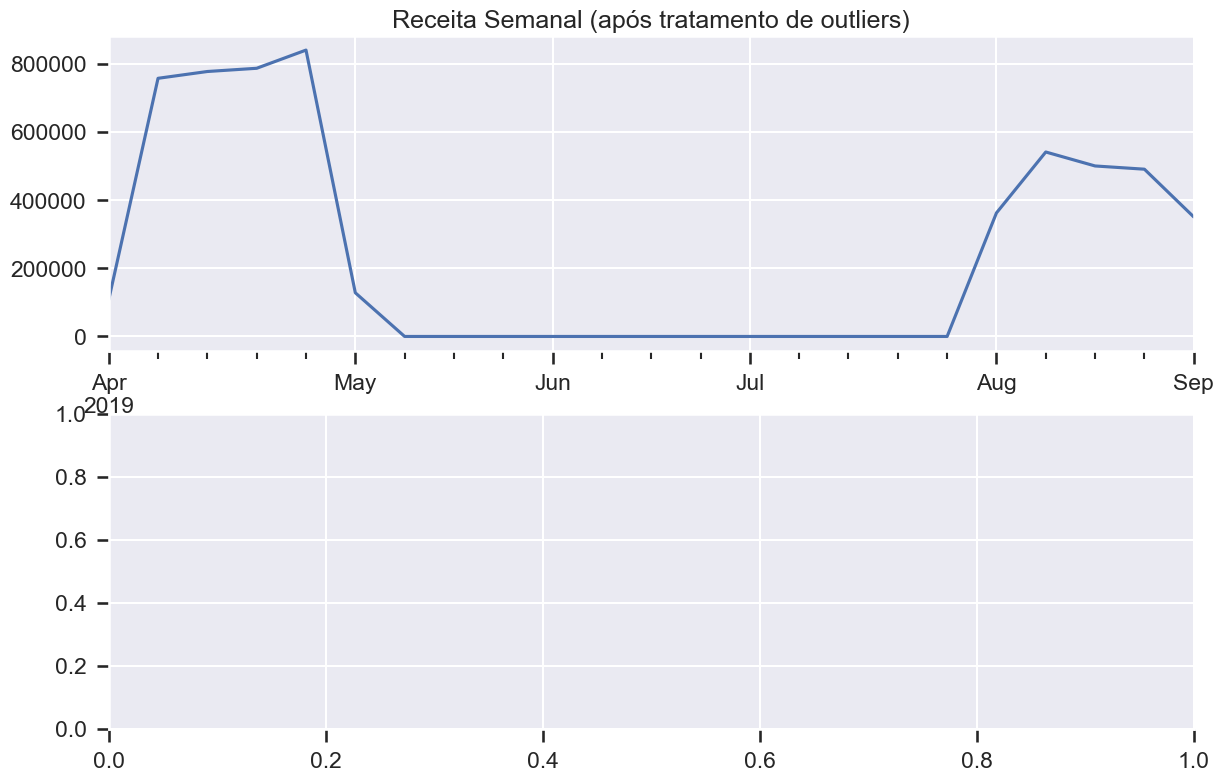

In [ ]:
# 4) Estatísticas descritivas e visualizações

print("Resumo estatístico da receita semanal:")
display(weekly_clean["revenue"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))

fig, ax = plt.subplots(2, 1, figsize=(14, 9), sharex=False)

weekly_clean["revenue"].plot(
    ax=ax[0],
    title="Receita Semanal (após tratamento de outliers)"
)

sns.boxplot(
    x=weekly_clean.index.isocalendar().week,
    y=weekly_clean["revenue"],
    ax=ax[1]
)

ax[1].set_title("Distribuição de Receita por Semana do Ano")
ax[1].set_xlabel("Semana ISO")



In [ ]:
# 5) Decomposição (aditiva e multiplicativa) e testes de estacionariedade

series = weekly_clean["revenue"].copy()
series.index = pd.PeriodIndex(series.index, freq="W-MON").to_timestamp()

# Escolha do modelo de decomposição baseada na variação relativa
cv = series.std() / (series.mean() + 1e-9)
model_type = "multiplicative" if cv > 0.3 else "additive"
print(f"Coeficiente de variação: {cv:.3f} | Decomposição: {model_type}")

try:
    decomp = seasonal_decompose(series, model=model_type, period=52)
    fig = decomp.plot()
    fig.set_size_inches(14, 9)
    plt.suptitle("Decomposição da Série Semanal de Receita", y=1.02)
    plt.show()
except Exception as e:
    print("Falha na decomposição (dados insuficientes?):", e)

# Teste ADF (H0: série tem raiz unitária -> não estacionária)
adf_stat, adf_p, _, _, crit_vals, _ = adfuller(series.dropna(), autolag="AIC")
print(f"ADF: stat={adf_stat:.3f}, p={adf_p:.4f}, crit={crit_vals}")

# Teste KPSS (H0: série é estacionária ao redor de uma tendência)
try:
    kpss_stat, kpss_p, _, kpss_crit = kpss(series.dropna(), regression='c', nlags='auto')
    print(f"KPSS: stat={kpss_stat:.3f}, p={kpss_p:.4f}, crit={kpss_crit}")
except Exception as e:
    print("Falha no KPSS:", e)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(series.dropna(), lags=30, ax=ax[0])
plot_pacf(series.dropna(), lags=30, ax=ax[1])
ax[0].set_title("ACF - Receita Semanal")
ax[1].set_title("PACF - Receita Semanal")
plt.tight_layout()
plt.show()


In [ ]:
# 6) Split treino/teste (80/20) e horizonte de previsão

y = series.copy().asfreq("W-MON")

n = len(y.dropna())
train_size = int(n * 0.8)
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print(f"Observações: {n} | Treino: {len(y_train)} | Teste: {len(y_test)}")

h = min(12, len(y_test))  # horizonte de 12 semanas ou tamanho do teste
print(f"Horizonte de avaliação: {h} semanas")


In [ ]:
# 7) Modelos: Holt-Winters e SARIMAX (sazonalidade semanal ~52)

results = {}

# Holt-Winters (tendência e sazonalidade)
hw_model = ExponentialSmoothing(
    y_train,
    trend="add",
    seasonal="mul" if (cv > 0.3) else "add",
    seasonal_periods=52,
    initialization_method="estimated"
)
hw_fit = hw_model.fit(optimized=True)

hw_forecast = hw_fit.forecast(steps=h)
results["HoltWinters"] = {
    "fit": hw_fit,
    "forecast": hw_forecast
}

# SARIMAX: configuração padrão razoável
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 52)

sarimax_model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarimax_fit = sarimax_model.fit(disp=False)

sarimax_forecast = sarimax_fit.get_forecast(steps=h).predicted_mean
results["SARIMAX"] = {
    "fit": sarimax_fit,
    "forecast": sarimax_forecast
}

list(results.keys())


In [ ]:
# 8) Avaliação (MAE, RMSE, MAPE) e comparação

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-9, None))) * 100

metrics = []
y_true = y_test.iloc[:h]

for name, obj in results.items():
    y_pred = obj["forecast"]
    y_pred.index = y_true.index  # alinhar índice
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape_val = mape(y_true, y_pred)
    metrics.append({"modelo": name, "MAE": mae, "RMSE": rmse, "MAPE%": mape_val})

metrics_df = pd.DataFrame(metrics).sort_values("RMSE")
metrics_df


In [ ]:
# 9) Previsão de 12 semanas com o melhor modelo e visualização

best = metrics_df.iloc[0]["modelo"]
print("Melhor modelo:", best)

best_fit = results[best]["fit"]
# Forecast para as próximas 12 semanas após o último ponto da série
future_steps = 12

if best == "SARIMAX":
    future_forecast = best_fit.get_forecast(steps=future_steps).predicted_mean
else:
    future_forecast = best_fit.forecast(steps=future_steps)

fig, ax = plt.subplots(figsize=(14, 6))
y.plot(ax=ax, label="Histórico")
y_test.iloc[:h].plot(ax=ax, label="Teste", color="tab:orange")
results[best]["forecast"].plot(ax=ax, label=f"{best} (previsão no teste)", color="tab:green")

future_forecast.index = pd.date_range(start=y.index.max() + pd.offsets.Week(weekday=0), periods=future_steps, freq="W-MON")
future_forecast.plot(ax=ax, label=f"{best} (12 semanas futuras)", color="tab:red")

ax.set_title("Previsão Semanal de Receita - 12 semanas")
ax.set_xlabel("Semana")
ax.set_ylabel("Receita")
ax.legend()
plt.tight_layout()
plt.show()

forecast_df = future_forecast.to_frame(name="forecast_revenue")
forecast_df.head(12)


In [ ]:
# 10) Variável exógena: basket_count semanal

def load_basket(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, parse_dates=["basket_date"])  # tem colunas: customer_id, product_id, basket_date, basket_count
    df = df.dropna(subset=["basket_date", "basket_count"]).copy()
    df["basket_count"] = pd.to_numeric(df["basket_count"], errors="coerce")
    df = df.dropna(subset=["basket_count"])  # remove linhas com basket_count inválido
    df = df.sort_values("basket_date")
    return df

baskets = load_basket(FILE_BASKET)
baskets_weekly = (
    baskets.set_index("basket_date")
           .resample("W-MON")
           .agg(basket_count=("basket_count", "sum"))
           .asfreq("W-MON")
           .interpolate(limit_direction="both")
)

# Alinhar com série de receita
y_exog = baskets_weekly.loc[y.index, "basket_count"].fillna(method="ffill")
print("Correlação receita x cestas (semanal):", pd.Series(y).corr(y_exog))

# Reajustar split
x_train, x_test = y_exog.iloc[:train_size], y_exog.iloc[train_size:]

# SARIMAX com exógena
sarimax_exog = SARIMAX(y_train, exog=x_train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
fit_exog = sarimax_exog.fit(disp=False)

pred_exog = fit_exog.get_forecast(steps=h, exog=x_test.iloc[:h]).predicted_mean

mae_exog = mean_absolute_error(y_true, pred_exog)
rmse_exog = mean_squared_error(y_true, pred_exog, squared=False)
mape_exog = mape(y_true, pred_exog)

print({"modelo": "SARIMAX_exog(basket)", "MAE": mae_exog, "RMSE": rmse_exog, "MAPE%": mape_exog})

fig, ax = plt.subplots(figsize=(14, 6))
y.plot(ax=ax, label="Histórico")
y_test.iloc[:h].plot(ax=ax, label="Teste", color="tab:orange")
pred_exog.plot(ax=ax, label="SARIMAX_exog (previsão no teste)", color="tab:purple")
ax.set_title("Teste com variável exógena: basket_count semanal")
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 11) Demografia dos clientes (customer_details)

def load_customers(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    # Limpeza simples: idades e tempo de relacionamento
    df["customer_age"] = pd.to_numeric(df["customer_age"], errors="coerce")
    df["tenure"] = pd.to_numeric(df["tenure"], errors="coerce")
    df = df.dropna(subset=["customer_age", "tenure"]).copy()
    return df

customers = load_customers(FILE_CUSTOMERS)

print("Resumo clientes:")
display(customers[["customer_age", "tenure"]].describe())

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(customers["customer_age"], bins=30, kde=True, ax=ax[0])
ax[0].set_title("Distribuição de Idade")
sns.histplot(customers["tenure"], bins=30, kde=True, ax=ax[1])
ax[1].set_title("Distribuição de Tempo de Relacionamento (meses)")
plt.tight_layout()
plt.show()

sex_share = customers["sex"].value_counts(normalize=True).mul(100).round(1)
print("Participação por sexo (%):\n", sex_share)


## Conclusões e próximos passos

- A série semanal de receita foi organizada, agregada e limpa (faltantes e outliers tratados de forma conservadora).
- A decomposição indicou padrões de tendência/sazonalidade; testes ADF/KPSS apontaram (provável) não estacionariedade original, justificando modelos com diferenciação/sazonalidade.
- Modelos Holt-Winters e SARIMAX foram treinados e comparados via MAE/RMSE/MAPE; foi gerada previsão de 12 semanas.
- A inclusão de `basket_count` como exógena foi testada e pode melhorar o desempenho dependendo da correlação no seu conjunto.
- A demografia de clientes foi sumarizada para contexto de negócio.

Próximos passos sugeridos:
- Ajuste fino de hiperparâmetros (grid de ordens SARIMA, variações de sazonalidade).
- Validação temporal com múltiplos folds (TimeSeriesSplit) para maior robustez.
- Considerar variáveis externas adicionais (promoções, feriados, marketing).
- Avaliar modelos não lineares (XGBoost/LSTM/GRU) se o horizonte for longo ou houver não linearidades fortes.
- Exportar a previsão (`forecast_df`) para CSV e integrar em dashboard (Power BI/Excel).
